In [1]:
import numpy as np
import depthai as dai
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt

In [2]:
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def detect_features(left_image, right_image):
    kp_left, des_left = sift.detectAndCompute(left_image, None)
    kp_right, des_right = sift.detectAndCompute(right_image, None)

    if len(kp_left) < 25 or len(kp_right) < 25:
        return None, None, None, None

    print(f'length of keypoints: {len(kp_left)}, {len(kp_right)}')
    matches = flann.knnMatch(des_left, des_right, k=2)

    filter_val = 0.6
    reprojection_threshold = 3.0
    kp_left_filtered, kp_right_filtered, des_left_filtered, des_right_filtered = filter_matches( kp_left, 
                    kp_right, 
                    des_left, 
                    des_right, 
                    matches, ratio = filter_val, reprojection_threshold=reprojection_threshold)

    print(f'length of filtered keypoints: {len(kp_left_filtered)}, {len(kp_right_filtered)}')

    if len(kp_left_filtered) < 25 or len(kp_right_filtered) < 25:
        return None, None, None, None
    return kp_left_filtered, kp_right_filtered, des_left_filtered, des_right_filtered

def filter_matches(kp_left, kp_right, des_left, des_right, matches, ratio = 0.75, reprojection_threshold = 5.0):
    # store all the good matches as per Lowe's ratio test.
    good = []
    pts_left_filtered = []
    pts_right_filtered = []
    kp_left_filtered = []
    kp_right_filtered = []
    des_left_filtered =  []
    des_right_filtered = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            pts_left_filtered.append(kp_left[m.queryIdx].pt)
            kp_left_filtered.append(kp_left[m.queryIdx])
            des_left_filtered.append(des_left[m.queryIdx])

            pts_right_filtered.append(kp_right[m.trainIdx].pt)
            kp_right_filtered.append(kp_right[m.trainIdx])
            des_right_filtered.append(des_right[m.trainIdx])

    if len(kp_left_filtered) < 25 or len(kp_right_filtered) < 25:
        return kp_left_filtered, kp_right_filtered, np.array(des_left_filtered), np.array(des_right_filtered)

    pts_left_filtered = np.float32(pts_left_filtered)
    pts_right_filtered = np.float32(pts_right_filtered)


    # this is just to get inliers
    M, mask = cv2.findHomography(pts_left_filtered, pts_right_filtered, method=cv2.RANSAC, ransacReprojThreshold=reprojection_threshold)
    matchesMask = mask.ravel().tolist()
    for i in reversed(range(len(pts_left_filtered))):
        if not matchesMask[i]:
            del kp_left_filtered[i]
            del kp_right_filtered[i]
            del des_left_filtered[i]
            del des_right_filtered[i]
    return kp_left_filtered, kp_right_filtered, np.array(des_left_filtered), np.array(des_right_filtered)

def epipolar_calculate(kp_left_filtered, kp_right_filtered, left_undistorted, right_undistorted, size, scale = 0.7):

    horStack = np.hstack((left_undistorted, right_undistorted))
    green = (0, 255, 0)
    red = (0, 0, 255)
    blue = (255, 0, 0)
    radius = 2
    thickness = 1
    epiploar_error = 0

    for i in range(len(kp_left_filtered)):
        left_pt = kp_left_filtered[i].pt
        right_pt = kp_right_filtered[i].pt
        
        left_pt_i = (int(left_pt[0]), int(left_pt[1]))
        right_pt_i = (size[0] + int(right_pt[0]), int(right_pt[1]))

        cv2.circle(horStack, left_pt_i, radius, red, thickness)
        cv2.circle(horStack, right_pt_i, radius, red, thickness)
        horStack = cv2.line(horStack, left_pt_i, right_pt_i, green, thickness)
        epiploar_error += abs(left_pt[1] - right_pt[1])
    
    epiploar_error /= len(kp_left_filtered)
    dest = cv2.resize(horStack, (0, 0), fx = scale, fy= scale, interpolation=cv2.INTER_AREA)
    return epiploar_error, dest

def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    plt.figure(figsize=(12, 8))
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.imshow(image)



## Read left and right Image

(1200, 1920, 3)


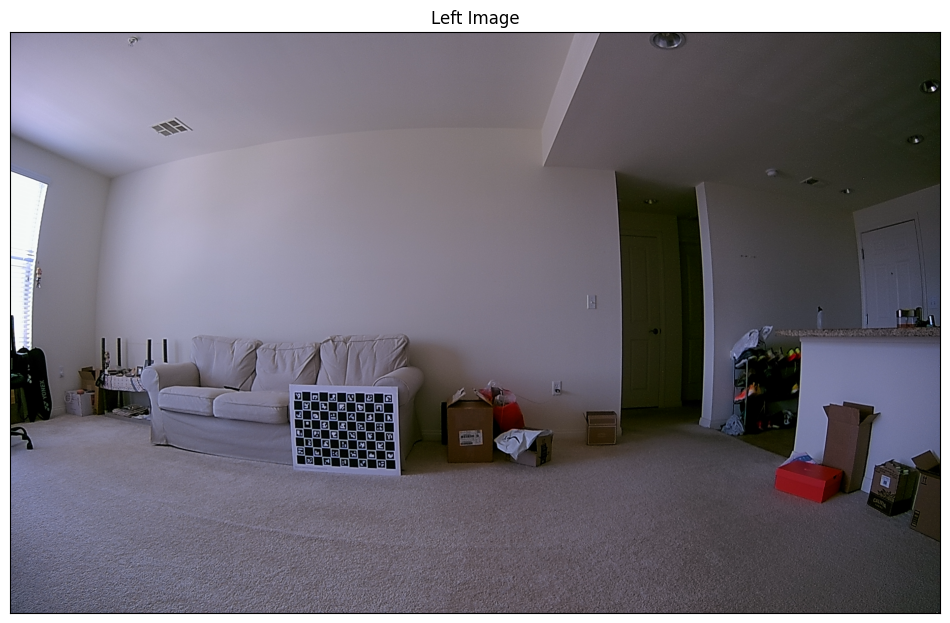

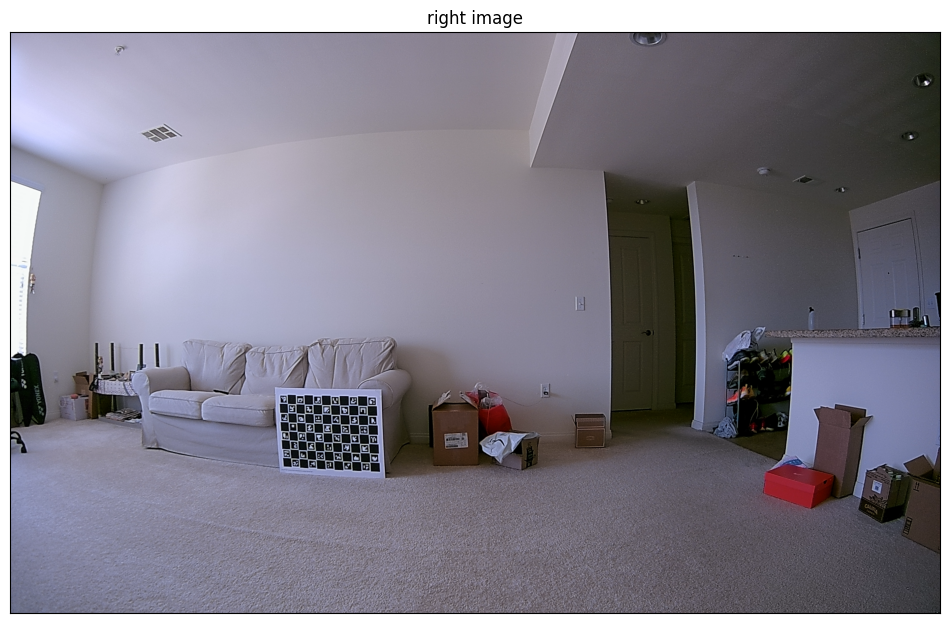

In [3]:
folder_name = "./dataset_07_static_15_may"
left_image = cv2.imread(folder_name + '/left/left_p0_0.png')
right_image = cv2.imread(folder_name + '/right/right_p0_0.png')
show_rgb_image(left_image, 'Left Image')
show_rgb_image(right_image, 'right image')
print(left_image.shape)

# Read the calibration data and undistort the images

In [4]:
calibration_handler = dai.CalibrationHandler('./calib_sensor_07_051923.json')
size = (1920, 1200)
M_left = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoLeftCameraId(), size[0], size[1]))
M_right = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoRightCameraId(), size[0], size[1]))
D_left = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoLeftCameraId()))
D_right = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoRightCameraId()))

transform = np.array(calibration_handler.getCameraExtrinsics(calibration_handler.getStereoRightCameraId(), calibration_handler.getStereoLeftCameraId())) 
R1 = np.array(calibration_handler.getStereoLeftRectificationRotation())
R2 = np.array(calibration_handler.getStereoRightRectificationRotation())

left_rot_right = transform[:3, :3]
left_t_right = transform[:3, 3]

In [5]:
M_focal = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(M_right, D_right, size, np.eye(3), fov_scale=1.1)
mapXL, mapYL = cv2.fisheye.initUndistortRectifyMap(M_left, D_left[:4], R1, M_focal, size, cv2.CV_32FC1)
mapXR, mapYR = cv2.fisheye.initUndistortRectifyMap(M_right, D_right[:4], R2, M_focal, size, cv2.CV_32FC1)

print(f'HFOV of the rectified image is {np.degrees(2*np.arctan(size[0]/(2*M_focal[0][0])))}')

HFOV of the rectified image is 109.77284451075366


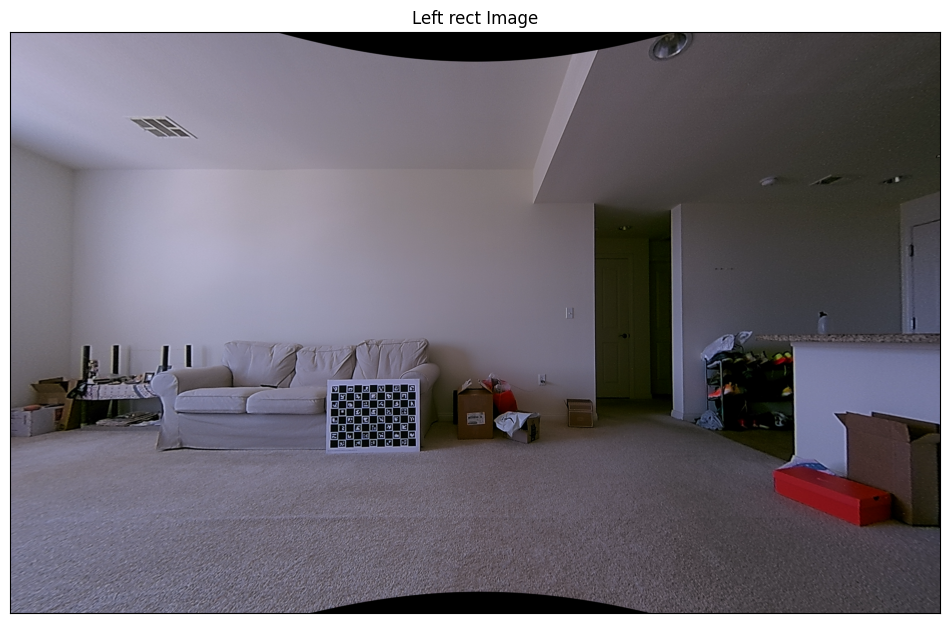

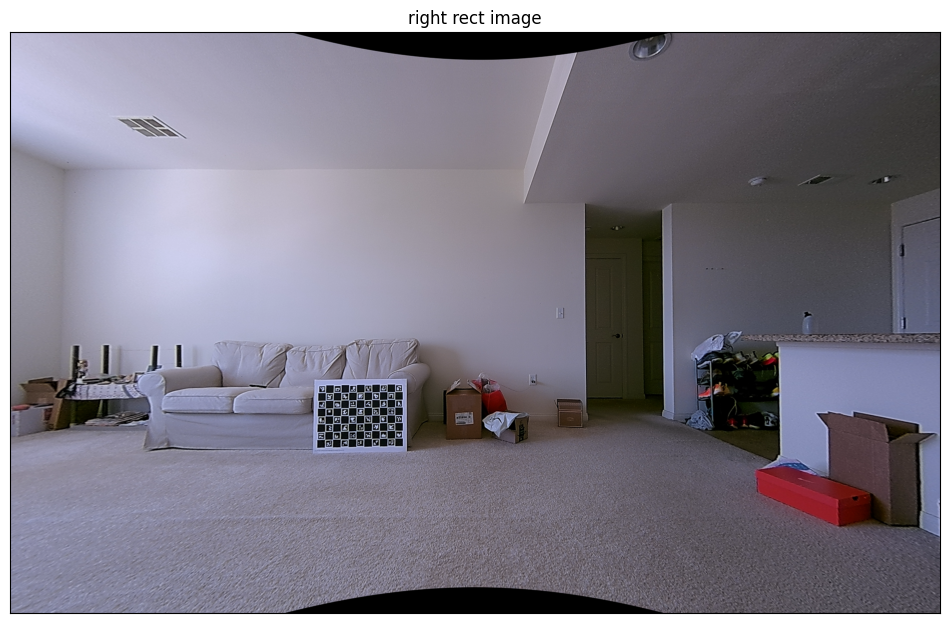

In [6]:
left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
cv2.imwrite('left_0.png', left_rect)
show_rgb_image(left_rect, 'Left rect Image')
show_rgb_image(right_rect, 'right rect image')

## Detect Features

length of keypoints: 6825, 6371
length of filtered keypoints: 554, 554
Average epipolar error is 0.13770461830857622


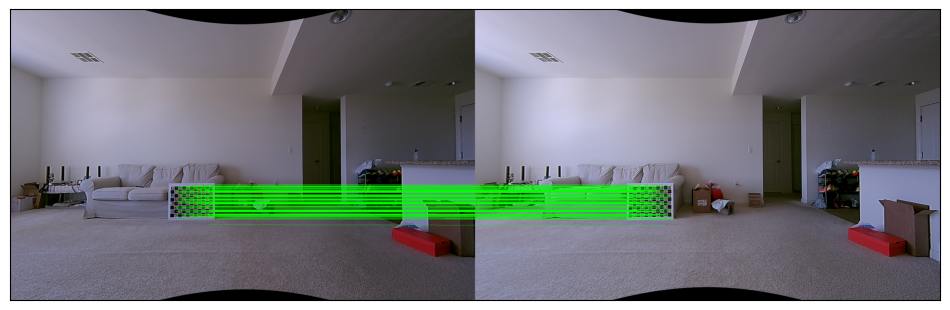

In [7]:
kp_left, kp_right, _, _ = detect_features(left_rect, right_rect)
kp_left_filtered = [] 
kp_right_filtered = []
pts_left_filtered = []
pts_right_filtered = []
for i in range(len(kp_left)):
    if kp_left[i].pt[1] < 950 and kp_left[i].pt[1] > 720 and kp_left[i].pt[0] < 900 and kp_left[i].pt[0] > 680:
        kp_left_filtered.append(kp_left[i])
        kp_right_filtered.append(kp_right[i])
        pts_left_filtered.append(kp_left[i].pt)
        pts_right_filtered.append(kp_right[i].pt)
        
pts_left_filtered = np.float32(pts_left_filtered)
pts_right_filtered = np.float32(pts_right_filtered)
ep_error, im_stack = epipolar_calculate(kp_left_filtered, kp_right_filtered, left_rect, right_rect, size, scale = 1)
print(f'Average epipolar error is {ep_error}')
show_rgb_image(im_stack)

## Visualize features

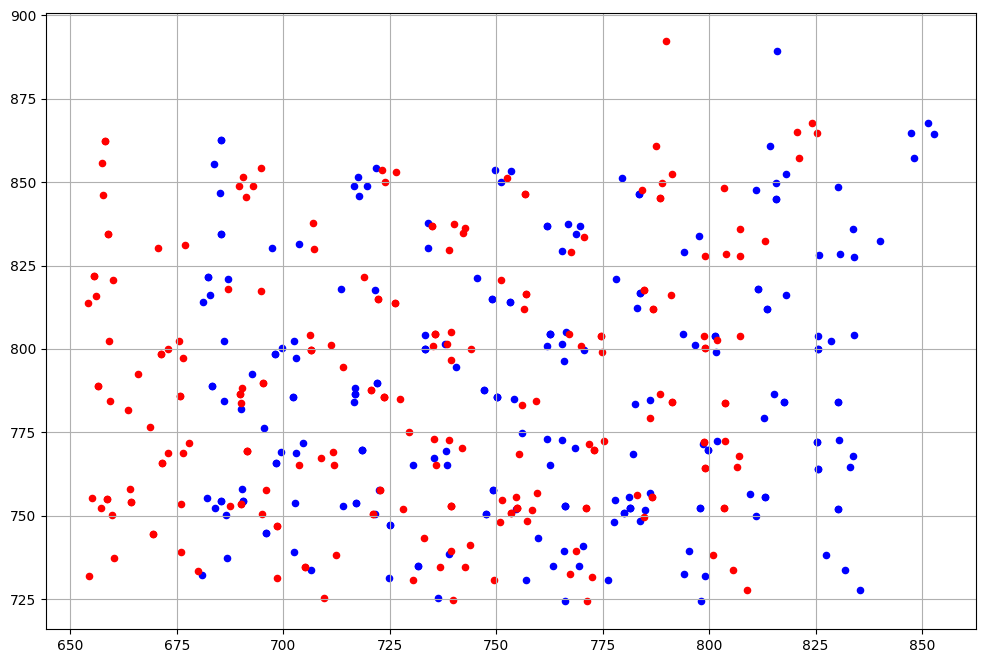

In [8]:
def display_overlay_points(left_pts, right_pts, markerSize = 20):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    # plt.xlim(0, size[0])
    # plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()

display_overlay_points(pts_left_filtered[None], pts_right_filtered[None])
    

In [21]:
def dispDepthConverter(disparity): # Does Disparity to Depth or Depth to disparity. 
    return left_t_right[0] * M_focal[0][0] / disparity

def test_flat_points(file_name, x_lower_bound, x_upper_bound):

    left_image = cv2.imread(folder_name + '/left/left_' + file_name)
    right_image = cv2.imread(folder_name + '/right/right_' + file_name)
    
    left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    
    kp_left, kp_right, _, _ = detect_features(left_rect, right_rect)

    kp_left_filtered = [] 
    kp_right_filtered = []
    pts_left_filtered = []
    pts_right_filtered = []
    
    for i in range(len(kp_left)):
        if kp_left[i].pt[1] < 900 and kp_left[i].pt[1] > 720 and kp_left[i].pt[0] < x_upper_bound and kp_left[i].pt[0] > x_lower_bound:
            kp_left_filtered.append(kp_left[i])
            kp_right_filtered.append(kp_right[i])
            pts_left_filtered.append(kp_left[i].pt)
            pts_right_filtered.append(kp_right[i].pt)

    pts_left_filtered = np.float32(pts_left_filtered)
    pts_right_filtered = np.float32(pts_right_filtered)

    ep_error, im_stack = epipolar_calculate(kp_left_filtered, kp_right_filtered, left_rect, right_rect, size, scale = 1)
    print(f'Average epipolar error is {ep_error}')
    show_rgb_image(im_stack)
    listDisparities = []
    y_offsets = []
    for i in range(len(pts_left_filtered)):
        curr_disparity = pts_left_filtered[i][0] - pts_right_filtered[i][0]
        # print(curr_disparity)
        # if curr_disparity > 10:
        listDisparities.append(curr_disparity)
        y_offsets.append(pts_left_filtered[i][1] - pts_right_filtered[i][1])
        # else:
            # print(curr_disparity)

    max_depth = dispDepthConverter(min(listDisparities))
    min_depth = dispDepthConverter(max(listDisparities))
    print(f'max Depth at min disparity is {max_depth} cm')
    print(f'min Depth at max disparity is {min_depth} cm')
    median_depth = dispDepthConverter(np.median(np.array(listDisparities)))
    gt_depth  = 255
    print(f'Depth at median disparity is {median_depth} cm')
    print(f' accuracy at median depth is {((median_depth - gt_depth) / gt_depth) * 100}')
    print(f' accuracy at max depth is {((max_depth - gt_depth) / gt_depth) * 100}')
    print(f' accuracy at min depth is {((min_depth - gt_depth) / gt_depth) * 100}')
    plt.figure(figsize=(12, 24))
    plt.rcParams["figure.autolayout"] = True
    plt.grid()

    plt.subplot(3, 1, 1)  # row 2, col 1 index 1
    plt.title('Histogram disparity')
    plt.hist(listDisparities, bins=25, edgecolor='black')
    # plt.show()

    plt.subplot(3, 1, 2)  # row 2, col 1 index 1
    plt.title('Histogram - y')
    plt.hist(y_offsets, bins=5, edgecolor='black', color='red')
    
    plt.subplot(3, 1, 3)  # row 2, col 1 index 2

    x = pts_left_filtered[:, 0]
    y = pts_left_filtered[:, 1]
    color = "blue"
    plt.scatter(x, y, c=color)

    for i in range(pts_left_filtered.shape[0]):
        x_pos = pts_left_filtered[i][0]
        y_pos = pts_right_filtered[i][1] + 2
        val = str(listDisparities[i])
        val = f"{listDisparities[i]:.2f}"
        plt.text(x = x_pos, y = y_pos, s=val, 
              fontdict=dict(color='red',size=8))
    plt.tight_layout()
    plt.show()
    return listDisparities



length of keypoints: 6825, 6371
length of filtered keypoints: 603, 603
Average epipolar error is 0.1379375457763672
max Depth at min disparity is 261.416092230022 cm
min Depth at max disparity is 249.07798115189206 cm
Depth at median disparity is 255.93719013143195 cm
 accuracy at median depth is 0.36752554173801855
 accuracy at max depth is 2.5161146000086285
 accuracy at min depth is -2.3223603325913484


/tmp/ipykernel_2551805/2966342293.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)  # row 2, col 1 index 1


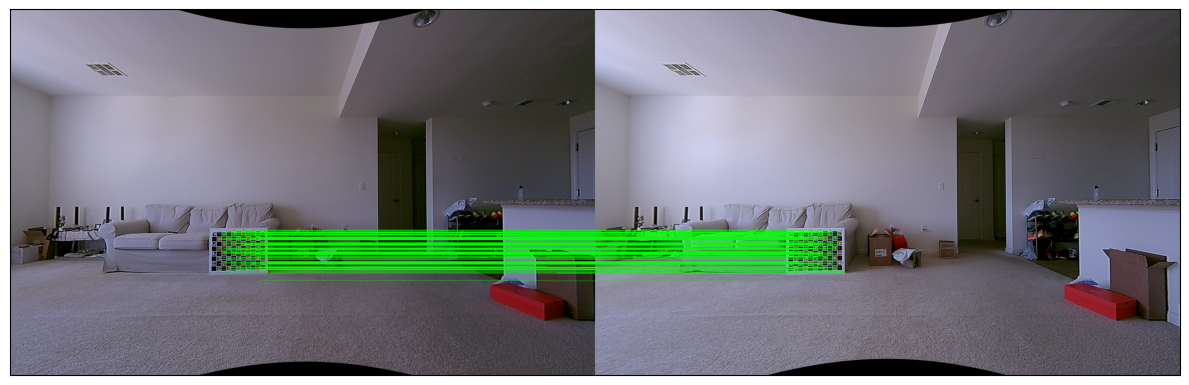

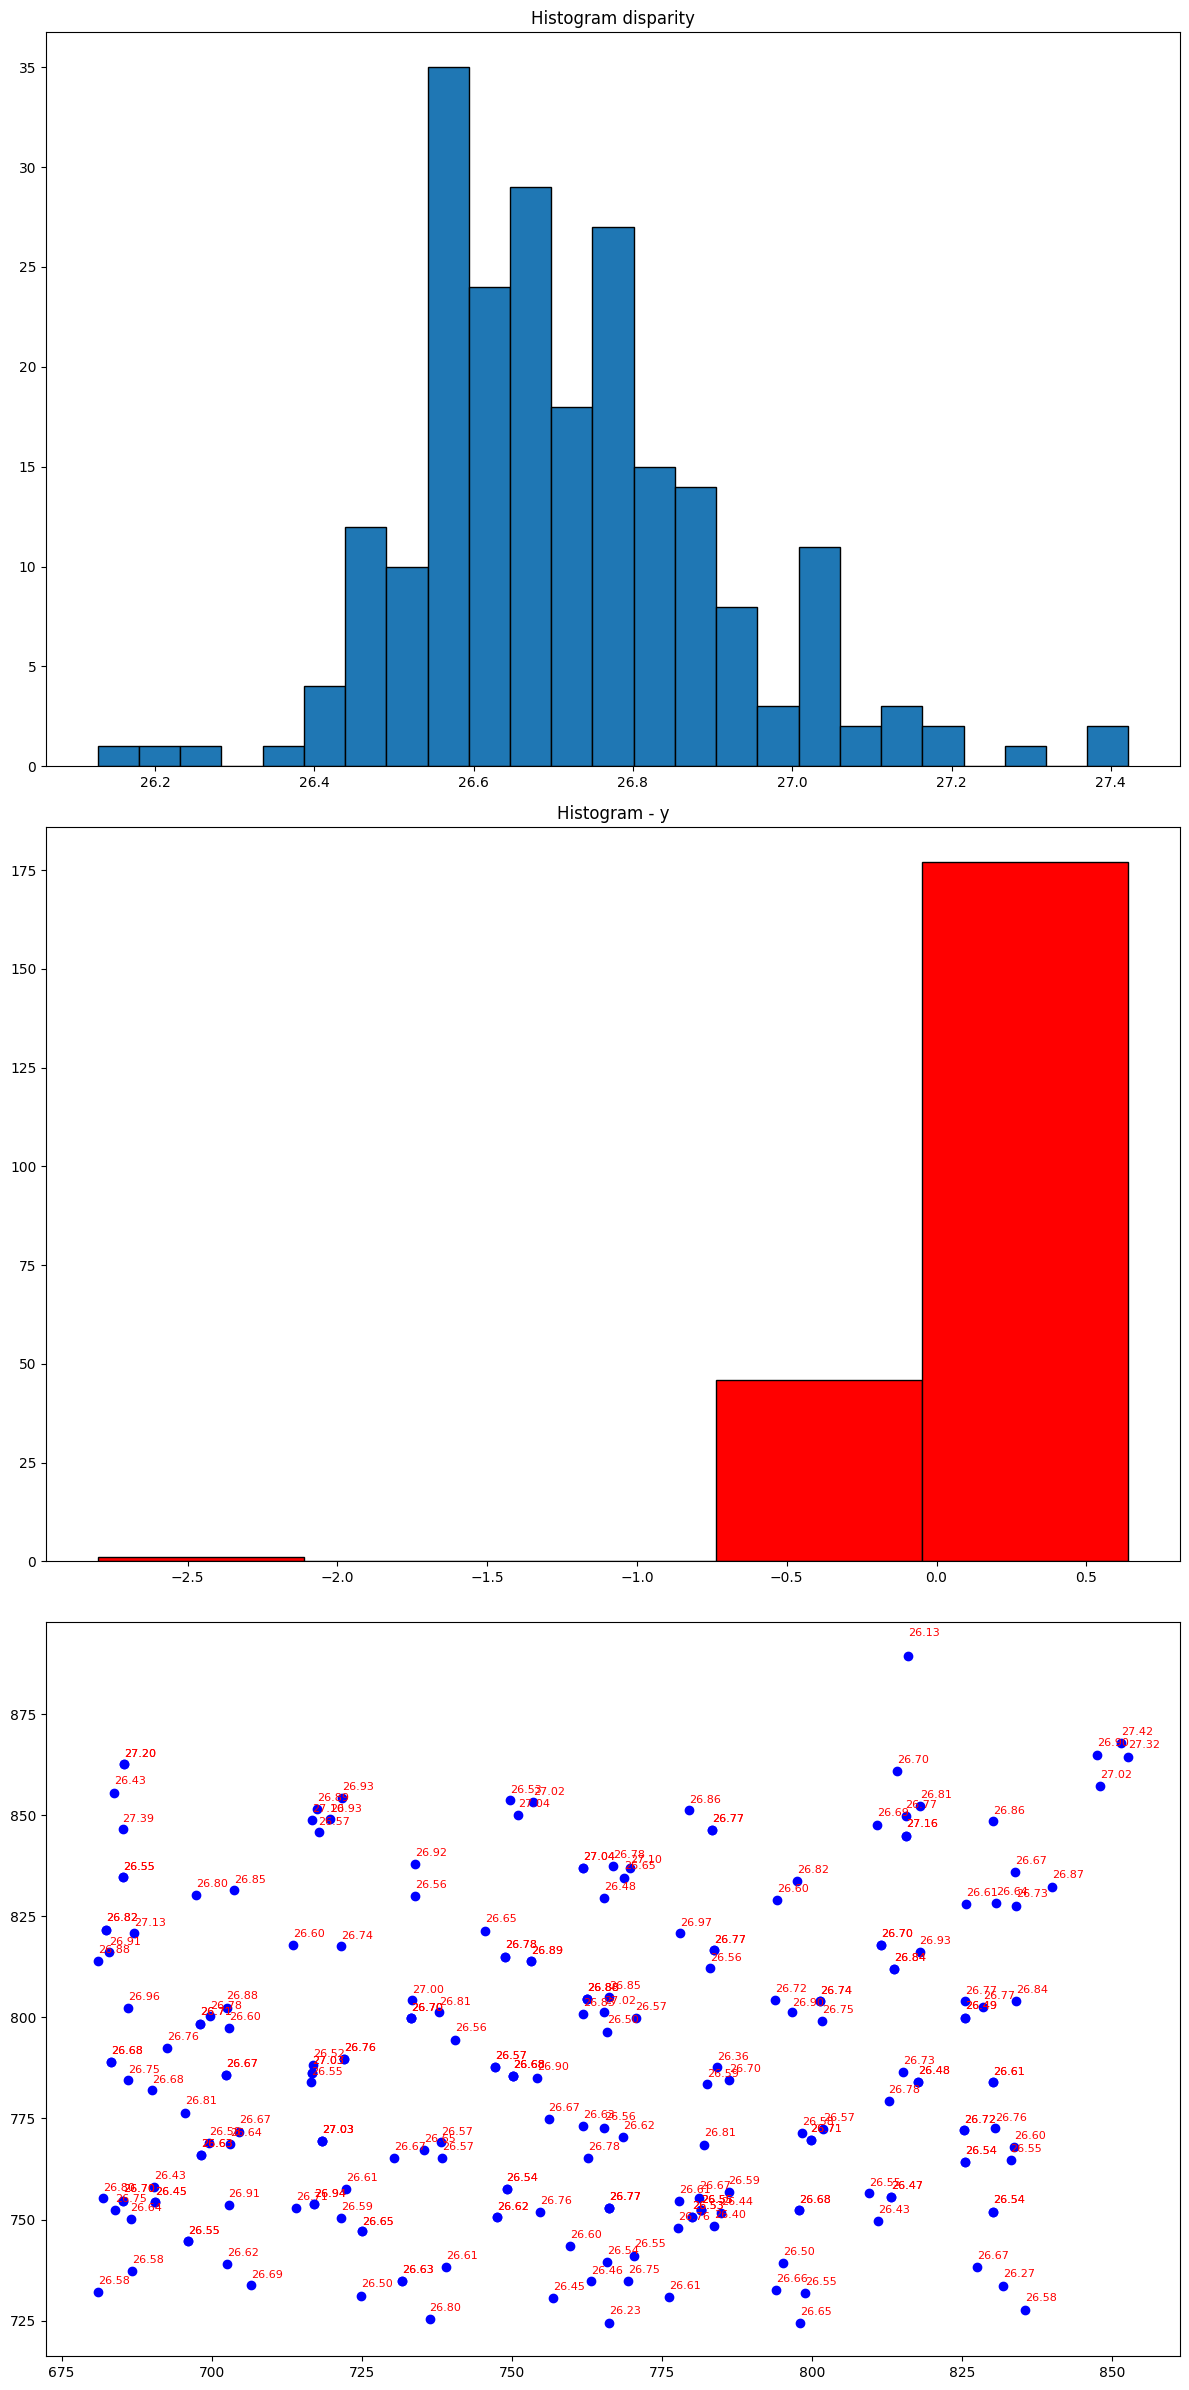

In [22]:
listDisparities = test_flat_points('p0_0.png', 680, 900)

length of keypoints: 7485, 7394
length of filtered keypoints: 867, 867
Average epipolar error is 0.2013575236002604
max Depth at min disparity is 262.5387261728819 cm
min Depth at max disparity is 248.52040951519973 cm
Depth at median disparity is 254.86003106826774 cm
 accuracy at median depth is -0.0548897771499041
 accuracy at max depth is 2.9563632050517343
 accuracy at min depth is -2.5410158763922626


/tmp/ipykernel_2551805/2966342293.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)  # row 2, col 1 index 1


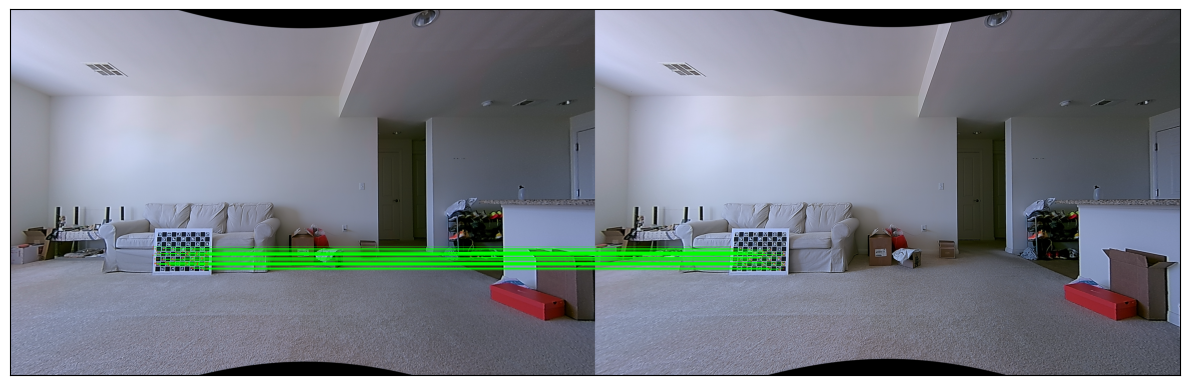

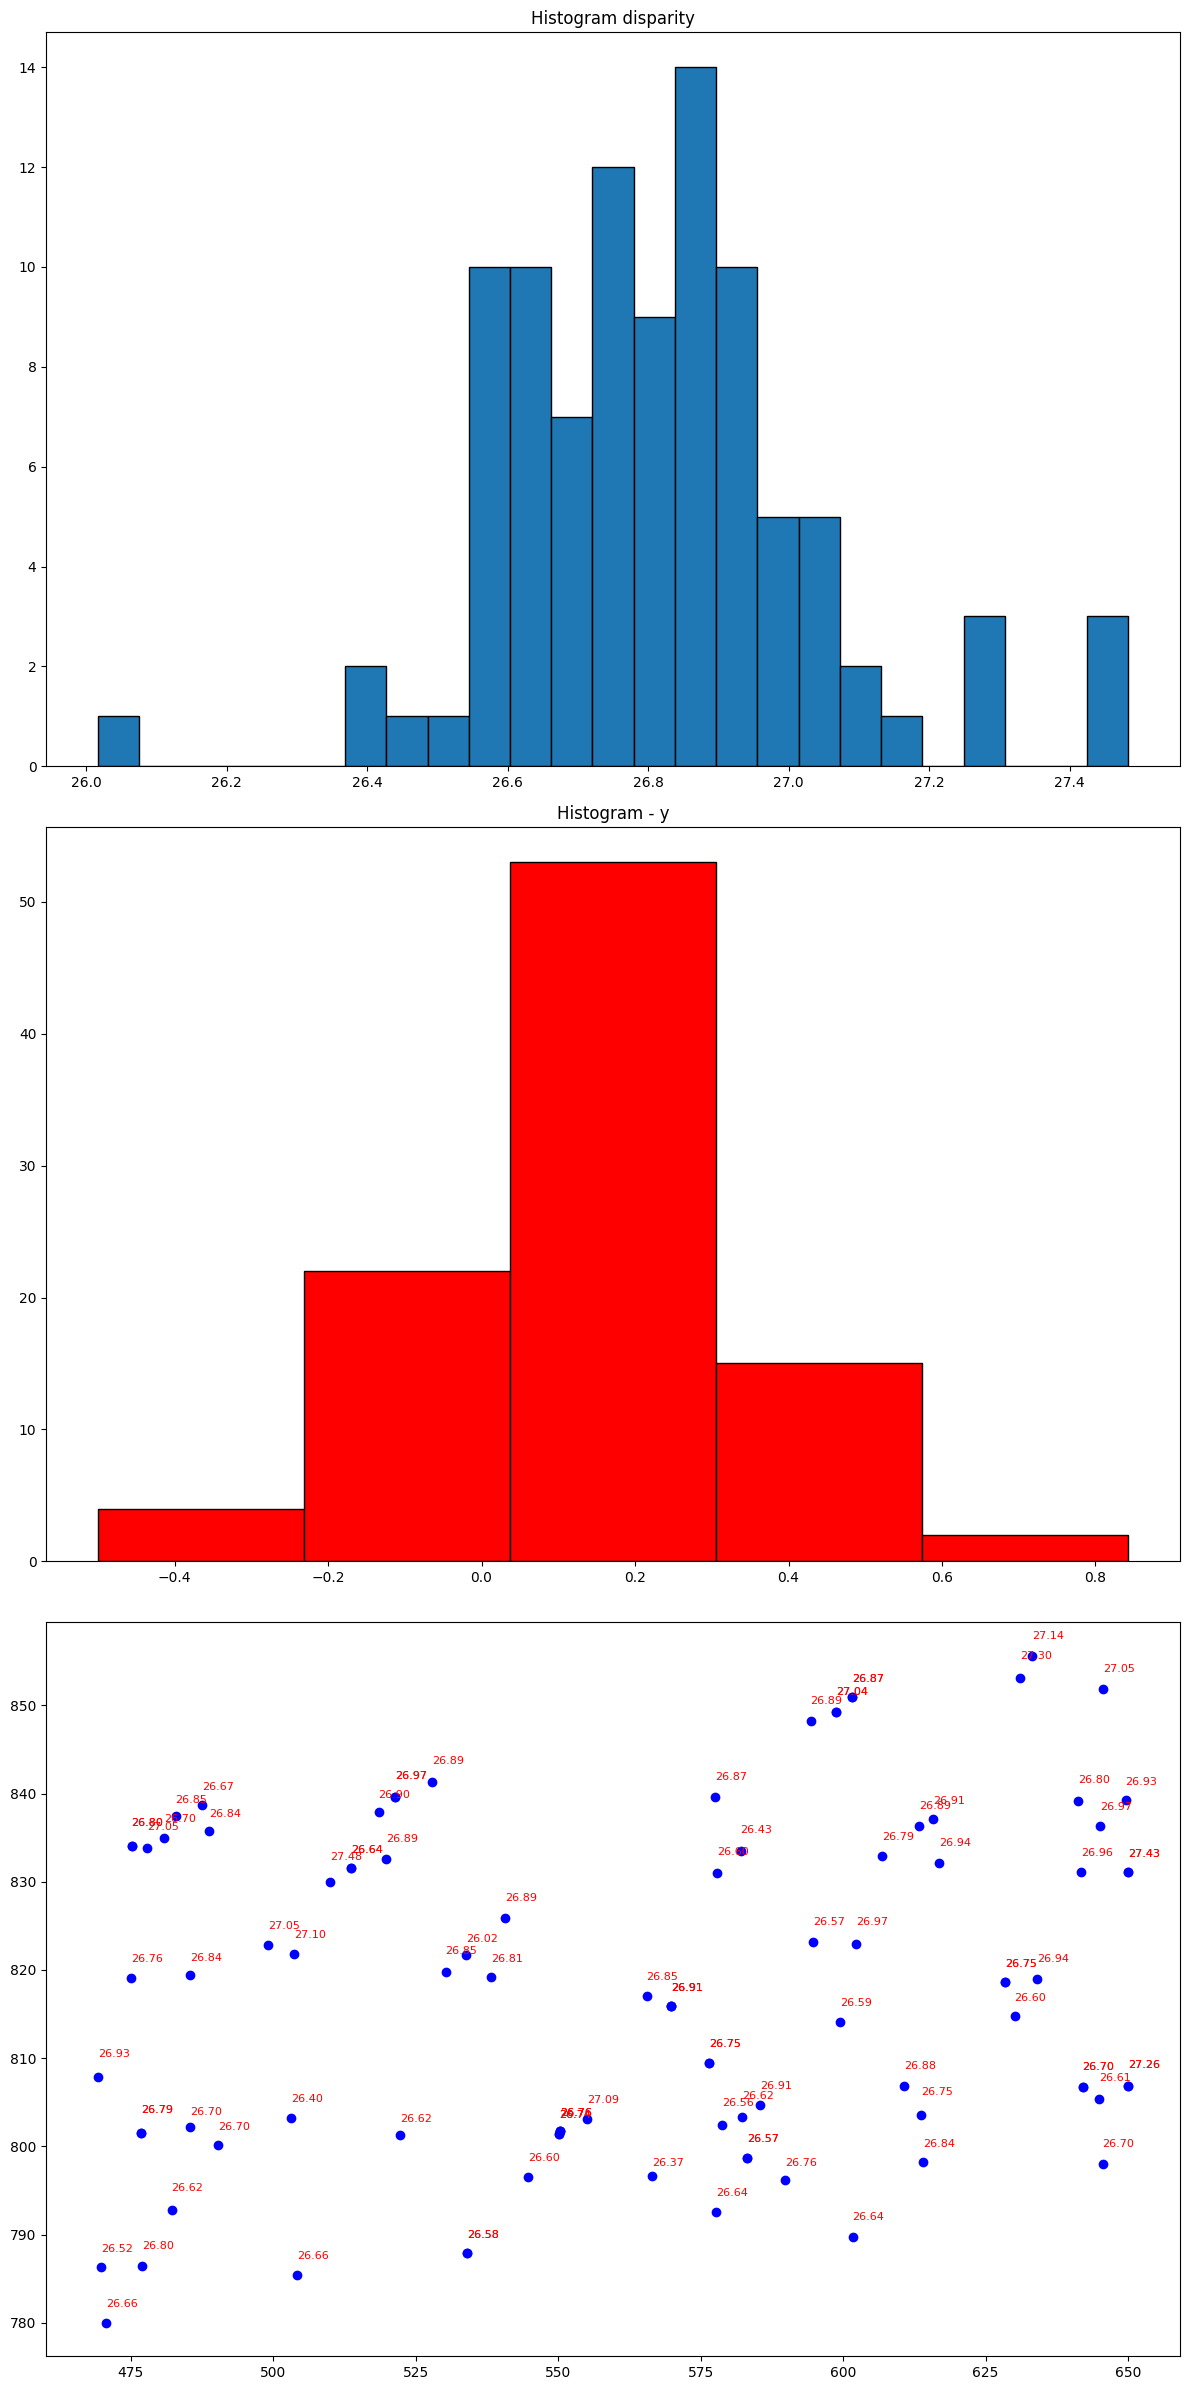

In [24]:
listDisparities = test_flat_points('p0_1.png', 450, 700)

length of keypoints: 7426, 7338
length of filtered keypoints: 811, 811
Average epipolar error is 0.23053368101728725
max Depth at min disparity is 262.9535918572381 cm
min Depth at max disparity is 248.33813762892487 cm
Depth at median disparity is 255.67172059691345 cm
 accuracy at median depth is 0.2634198419268413
 accuracy at max depth is 3.1190556302894548
 accuracy at min depth is -2.612495047480443


/tmp/ipykernel_2551805/2966342293.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)  # row 2, col 1 index 1


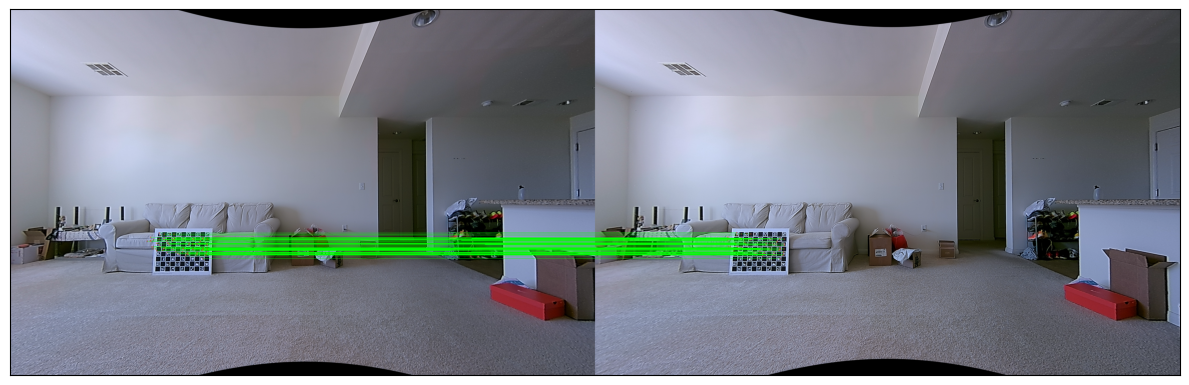

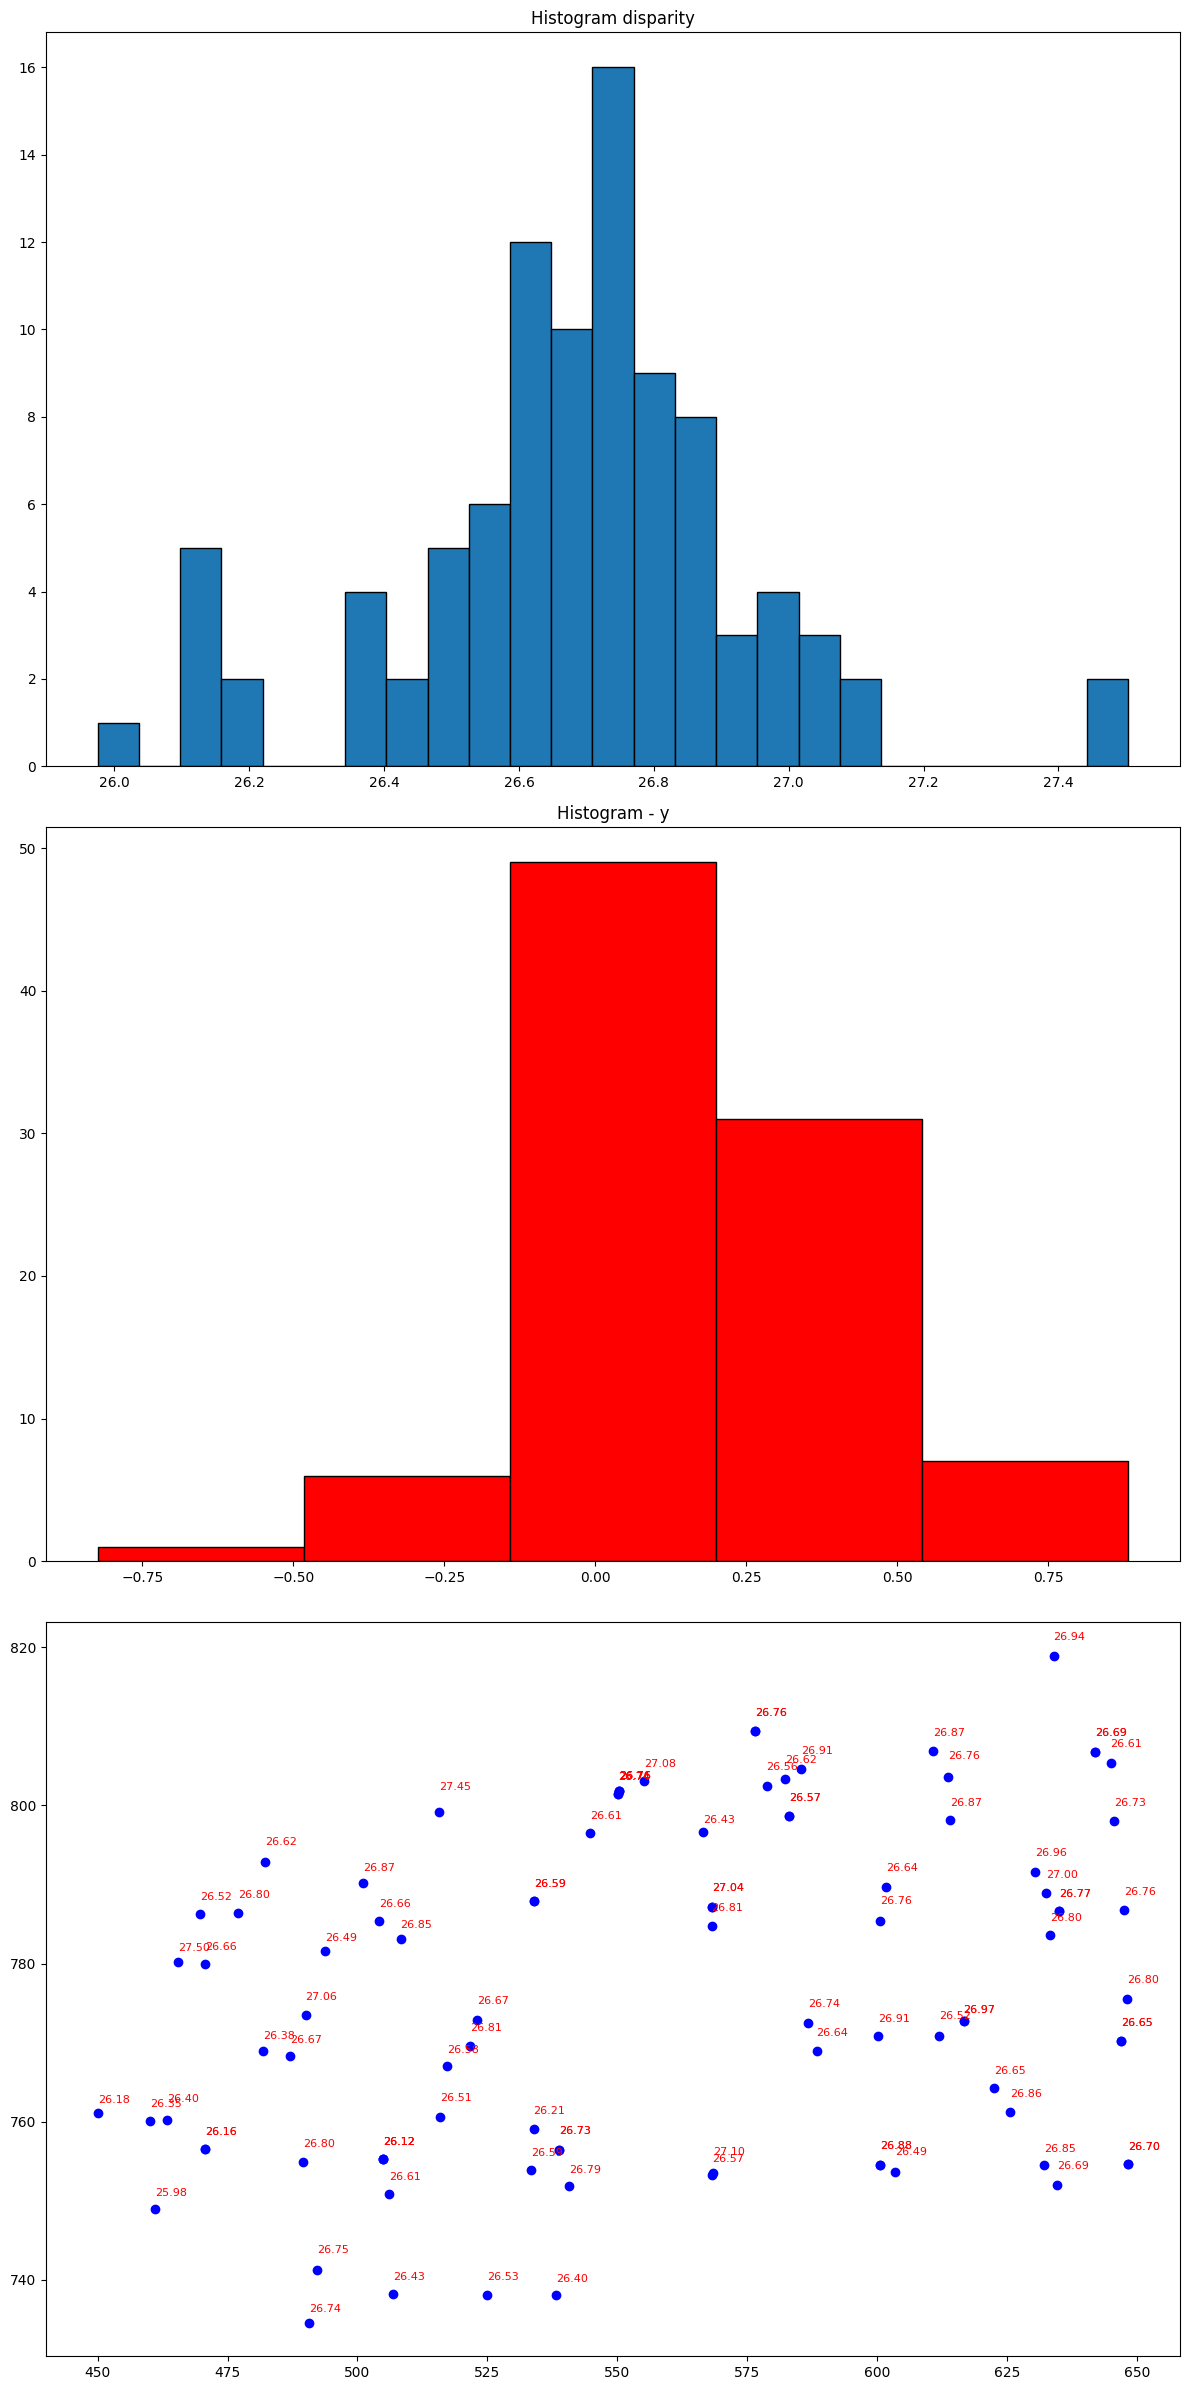

In [31]:
listDisparities = test_flat_points('p0_2.png', 440, 650)

length of keypoints: 7522, 7310
length of filtered keypoints: 813, 813
Average epipolar error is 0.30643814329117064
max Depth at min disparity is 289.4200213930547 cm
min Depth at max disparity is 250.90468183022915 cm
Depth at median disparity is 255.1883937860789 cm
 accuracy at median depth is 0.07387991610937437
 accuracy at max depth is 13.49804760511949
 accuracy at min depth is -1.6060071254003327


/tmp/ipykernel_2551805/2966342293.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)  # row 2, col 1 index 1


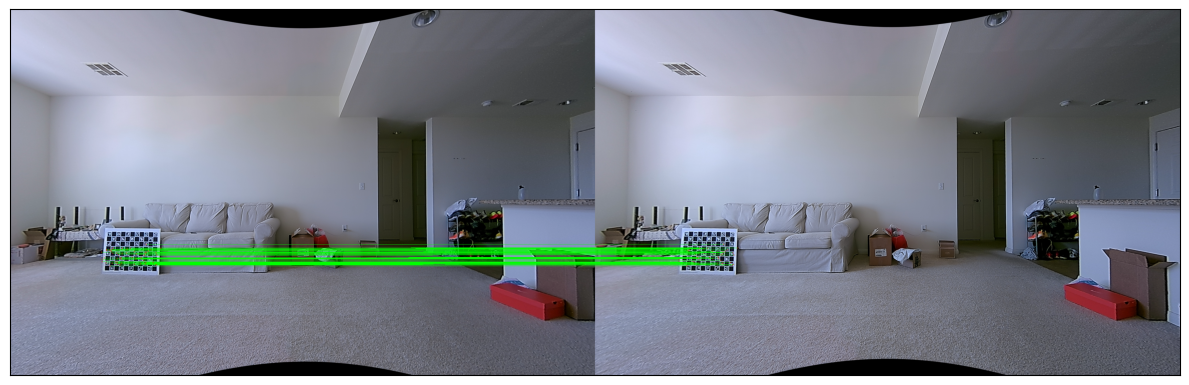

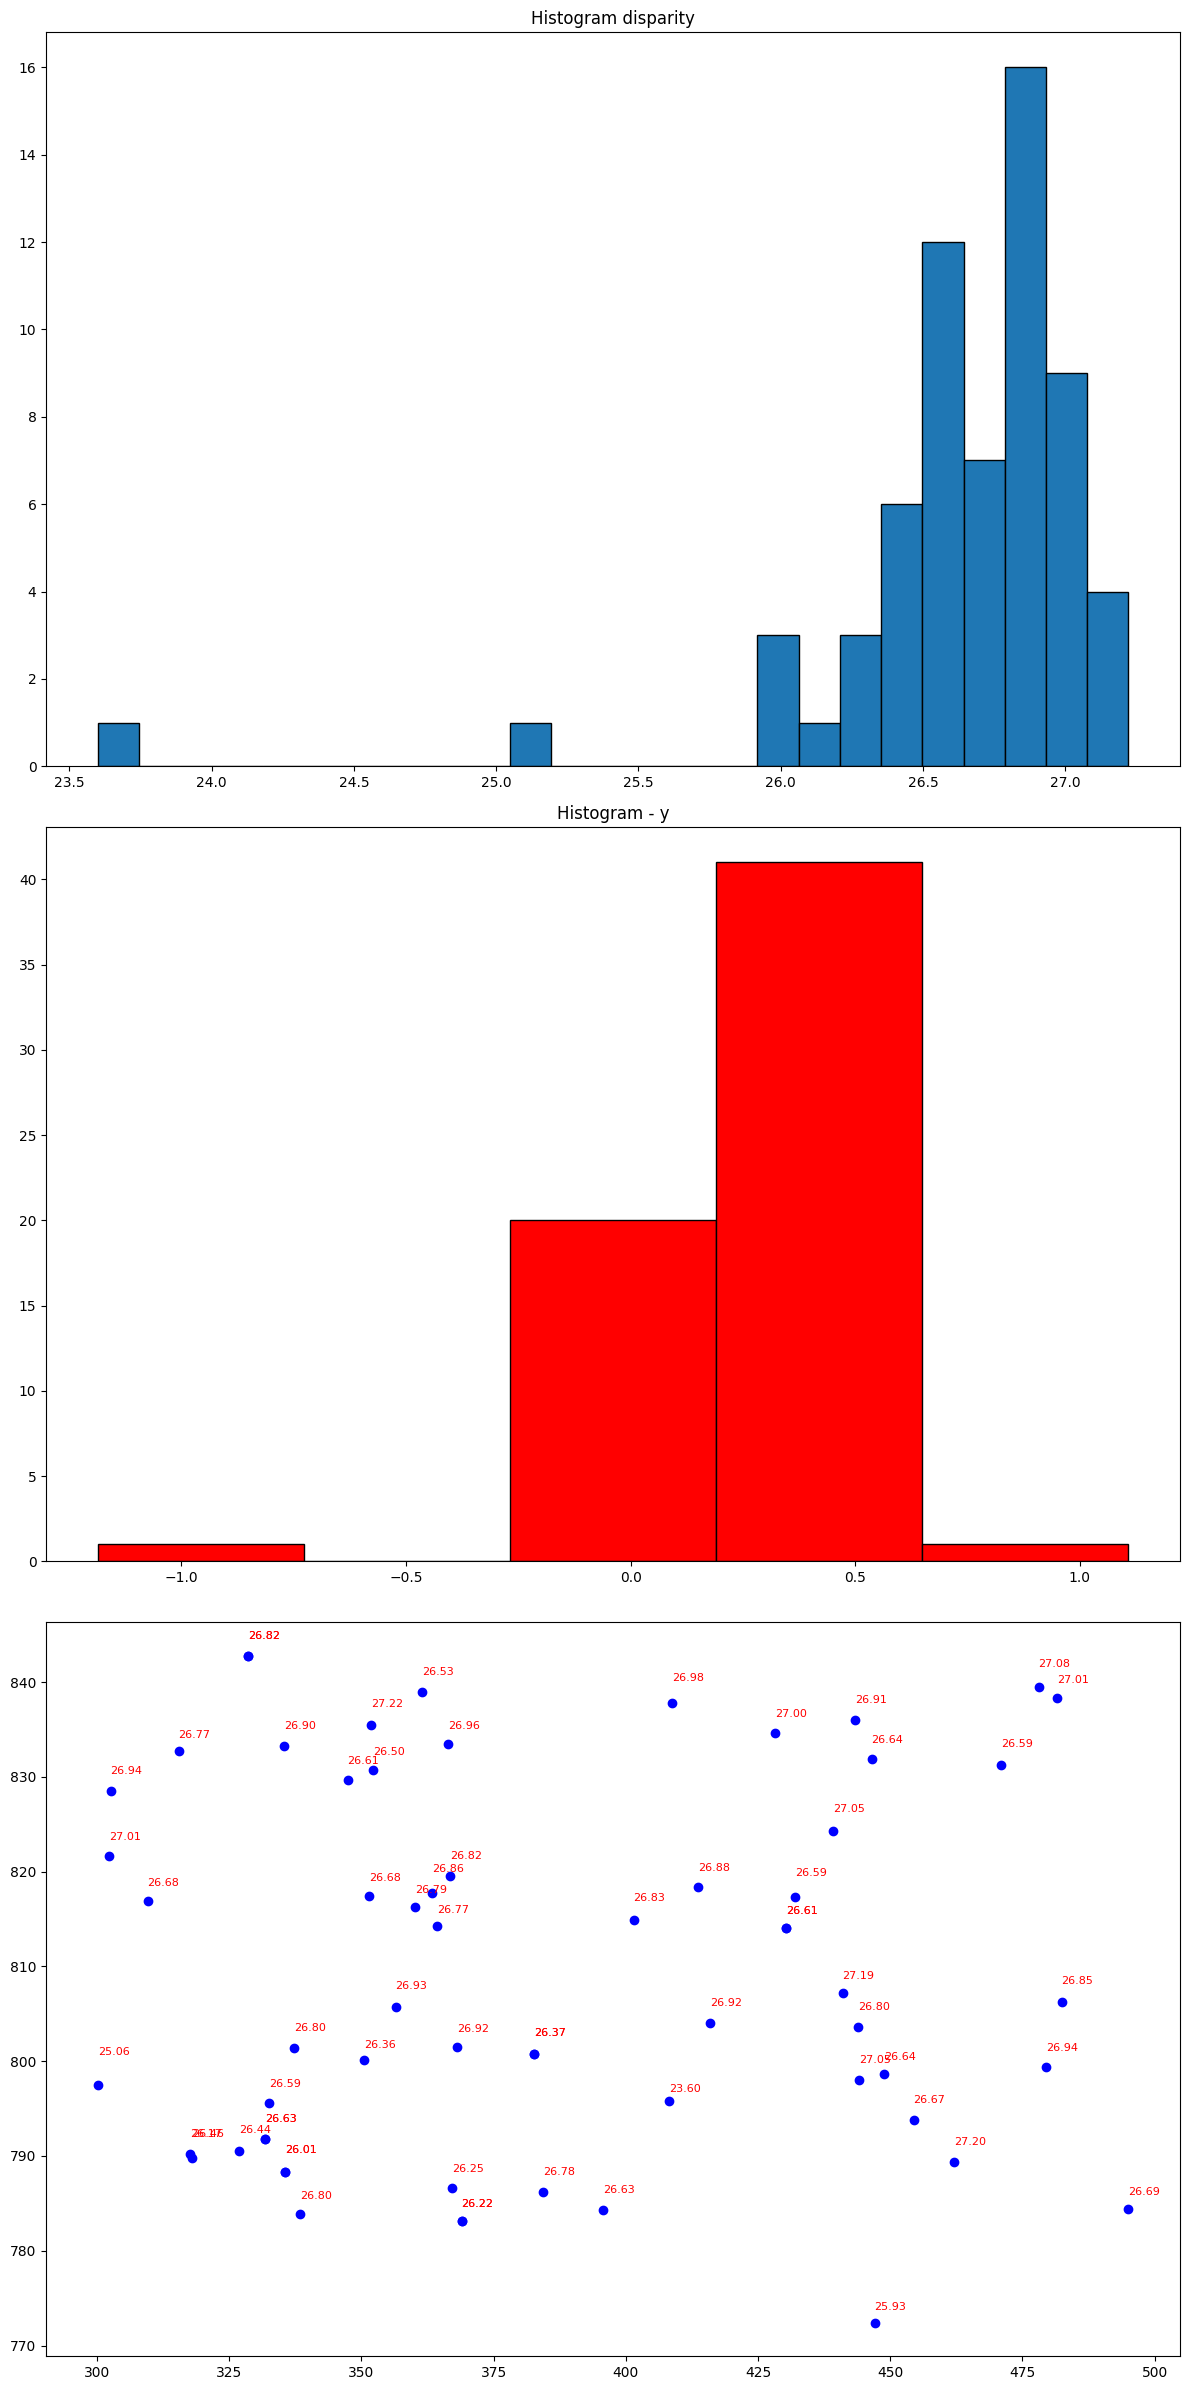

In [37]:
listDisparities = test_flat_points('p1_3.png', 300, 500)

length of keypoints: 7258, 6993
length of filtered keypoints: 738, 738
Average epipolar error is 0.39074489048549105
max Depth at min disparity is 304.7397844674885 cm
min Depth at max disparity is 245.08760569826507 cm
Depth at median disparity is 251.4234730903206 cm
 accuracy at median depth is -1.402559572423289
 accuracy at max depth is 19.50579783038765
 accuracy at min depth is -3.8872134516607586


/tmp/ipykernel_2551805/2966342293.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)  # row 2, col 1 index 1


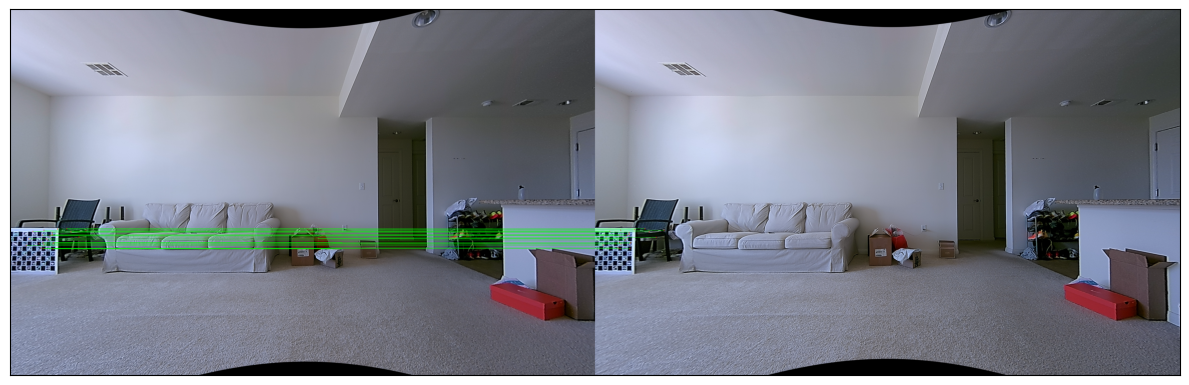

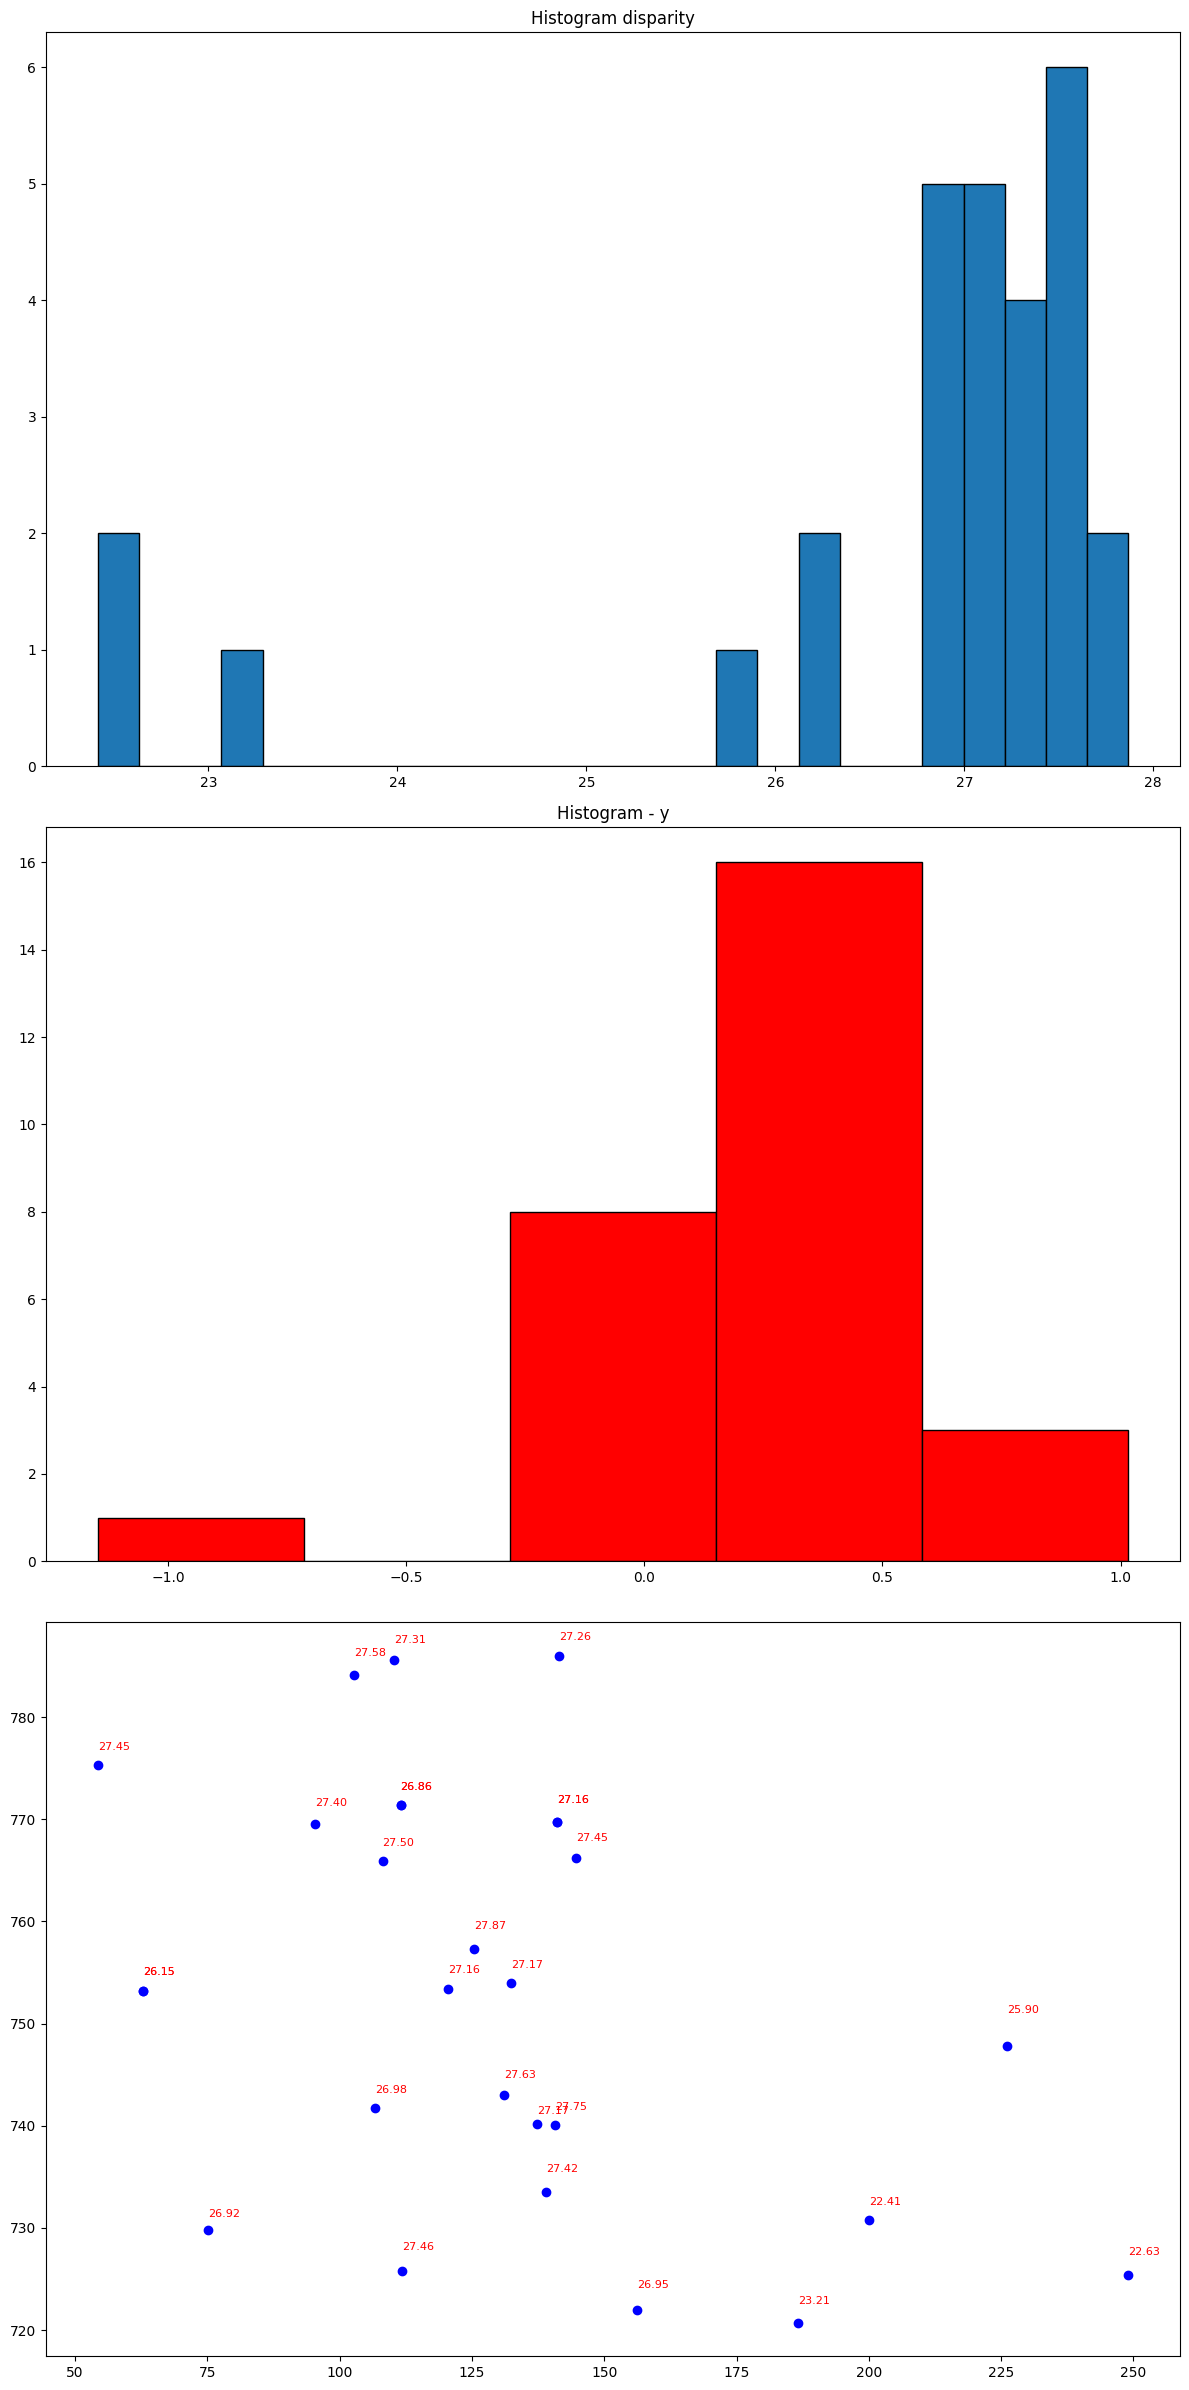

In [38]:
listDisparities = test_flat_points('p1_4.png', 0, 250)

length of keypoints: 7252, 7001
length of filtered keypoints: 713, 713
Average epipolar error is 0.41147030101102944
max Depth at min disparity is 301.8830789117994 cm
min Depth at max disparity is 245.08760569826507 cm
Depth at median disparity is 251.37790278658295 cm
 accuracy at median depth is -1.420430279771392
 accuracy at max depth is 18.38552114188211
 accuracy at min depth is -3.8872134516607586


/tmp/ipykernel_2551805/2966342293.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)  # row 2, col 1 index 1


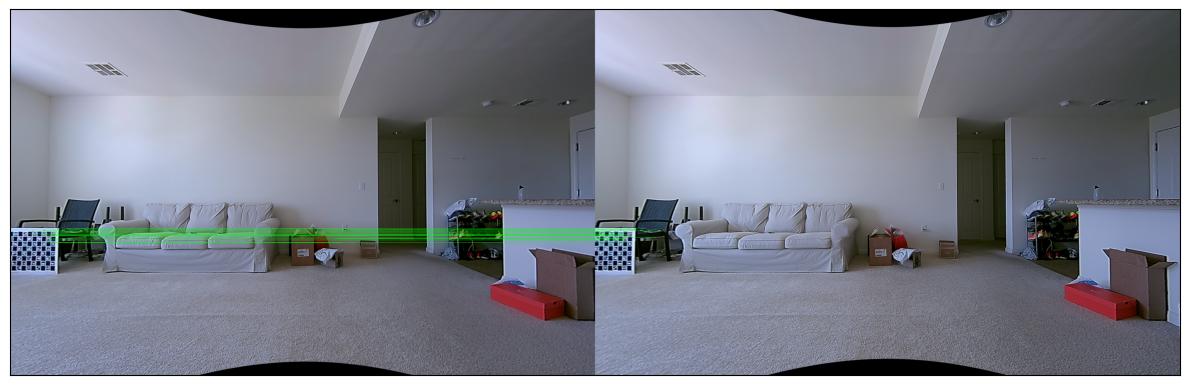

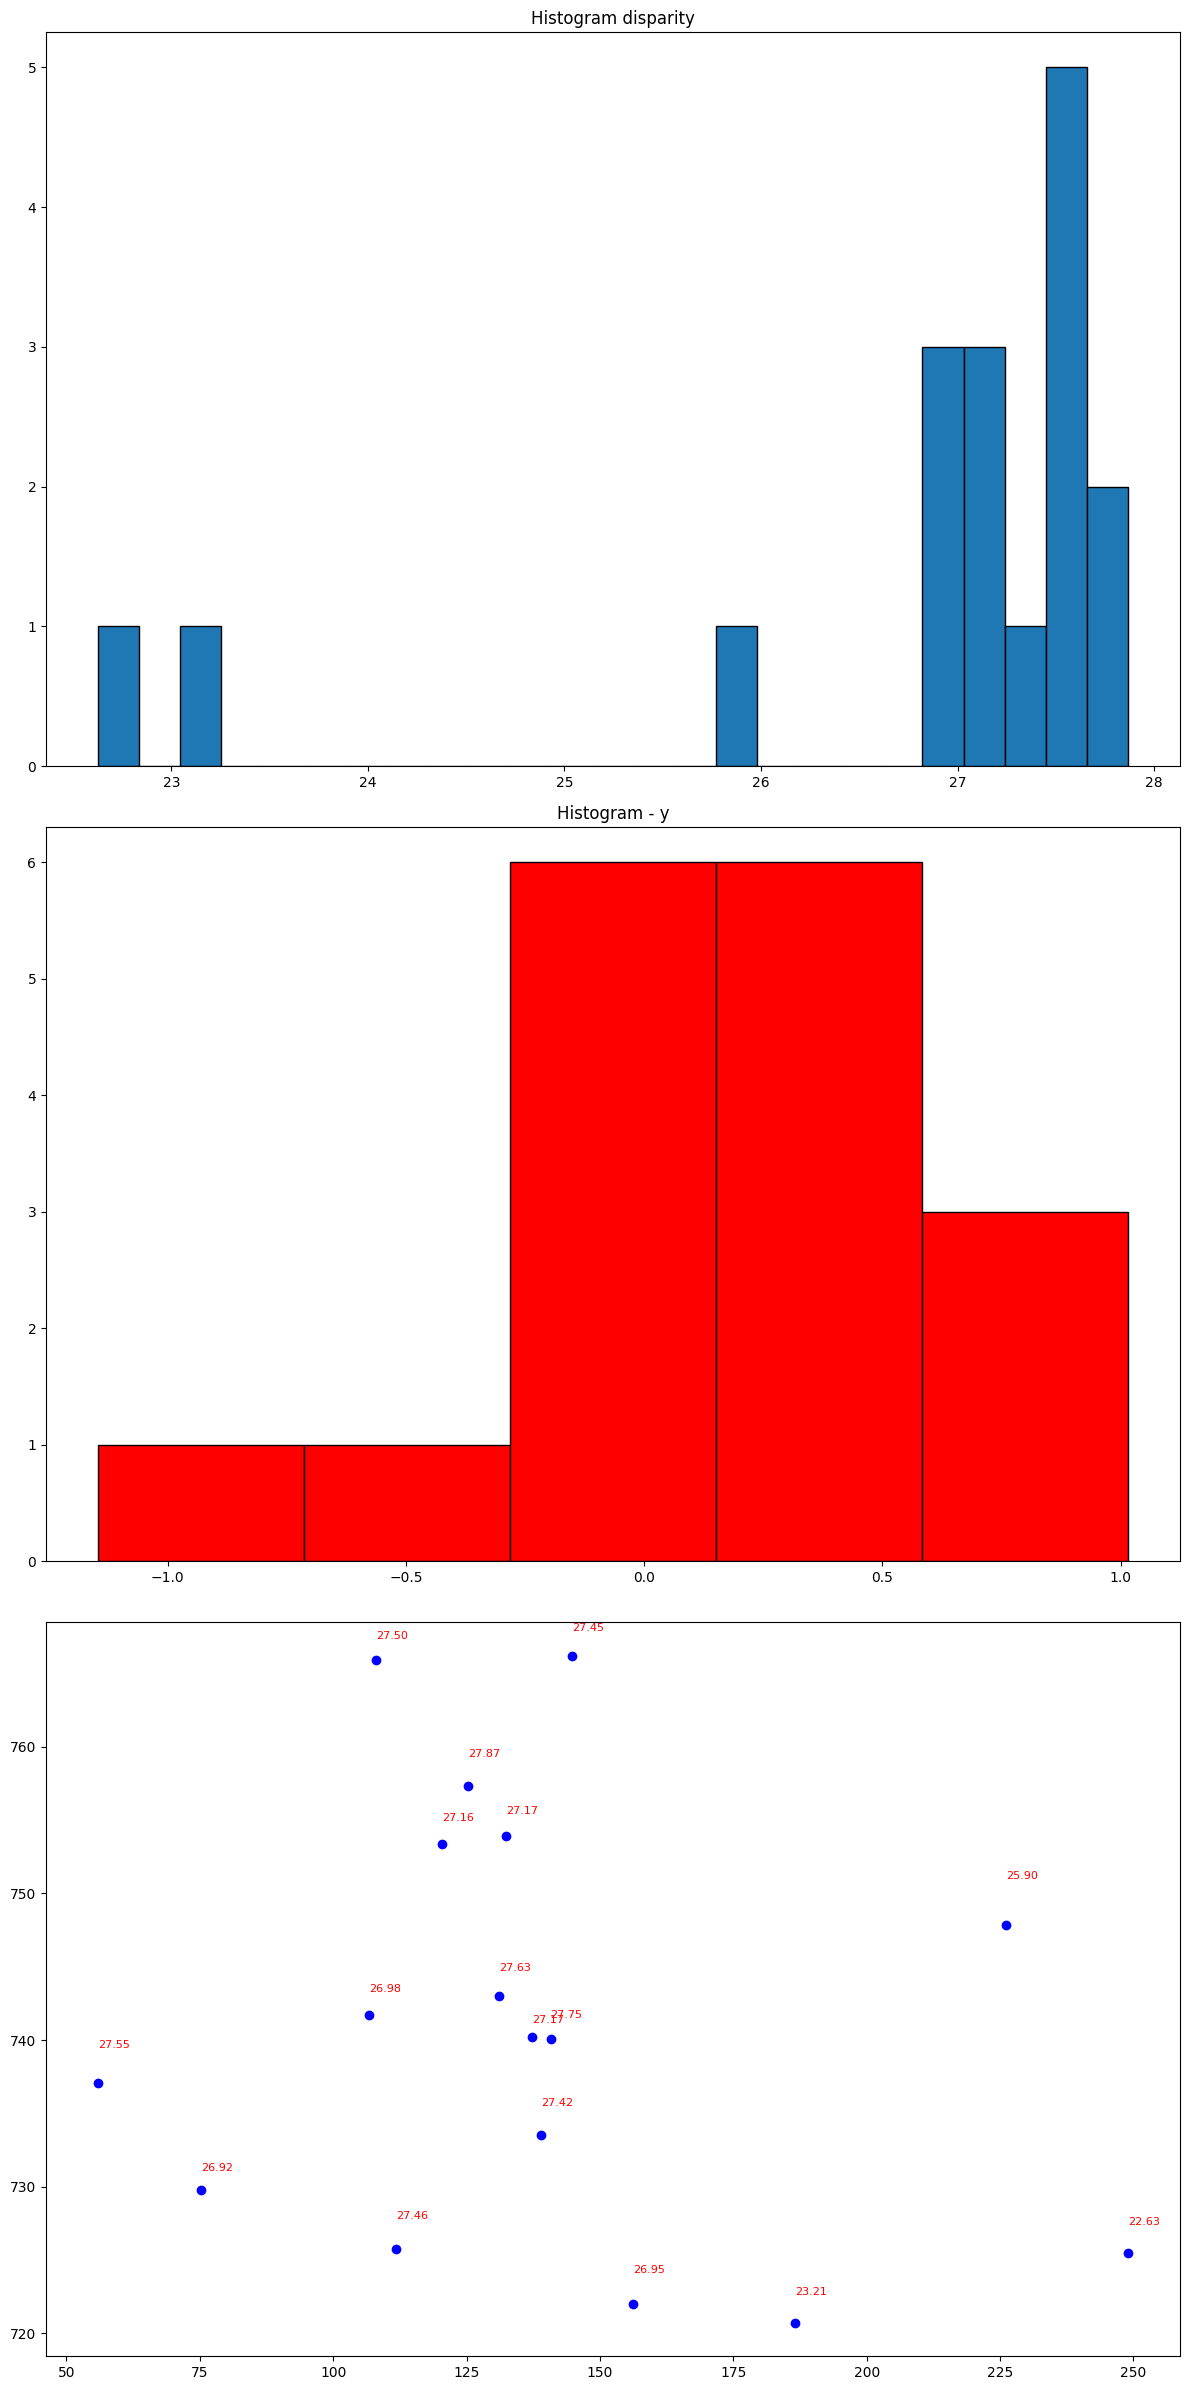

In [40]:
listDisparities = test_flat_points('p1_5.png', 0, 250)